In [143]:
# Path: src\analysis.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from values import Values
plt.rcParams['font.size'] = 17

In [144]:
directory = '../data/c3_data'

c3_data = {}

for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        c3_data[filename] = pd.DataFrame(pd.read_csv(os.path.join(directory, filename))).drop(0).reset_index(drop=True).astype(np.float64)

## Viewing the Data

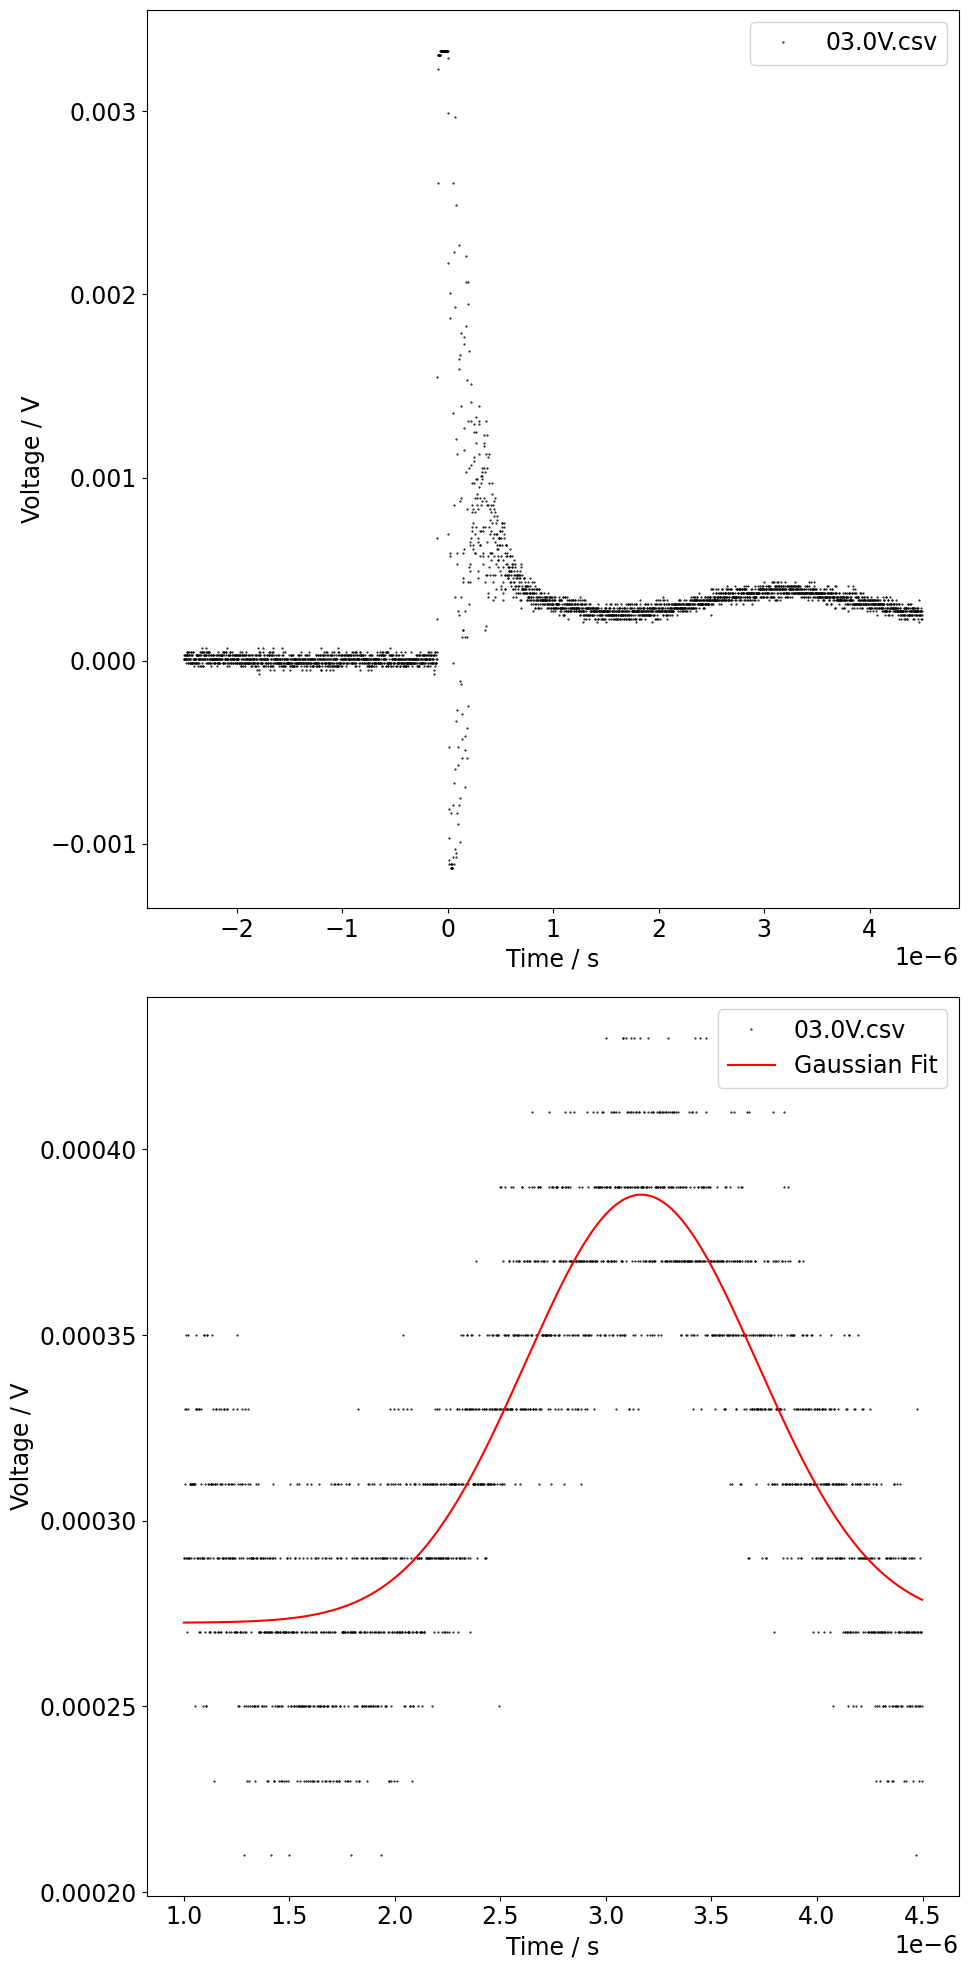

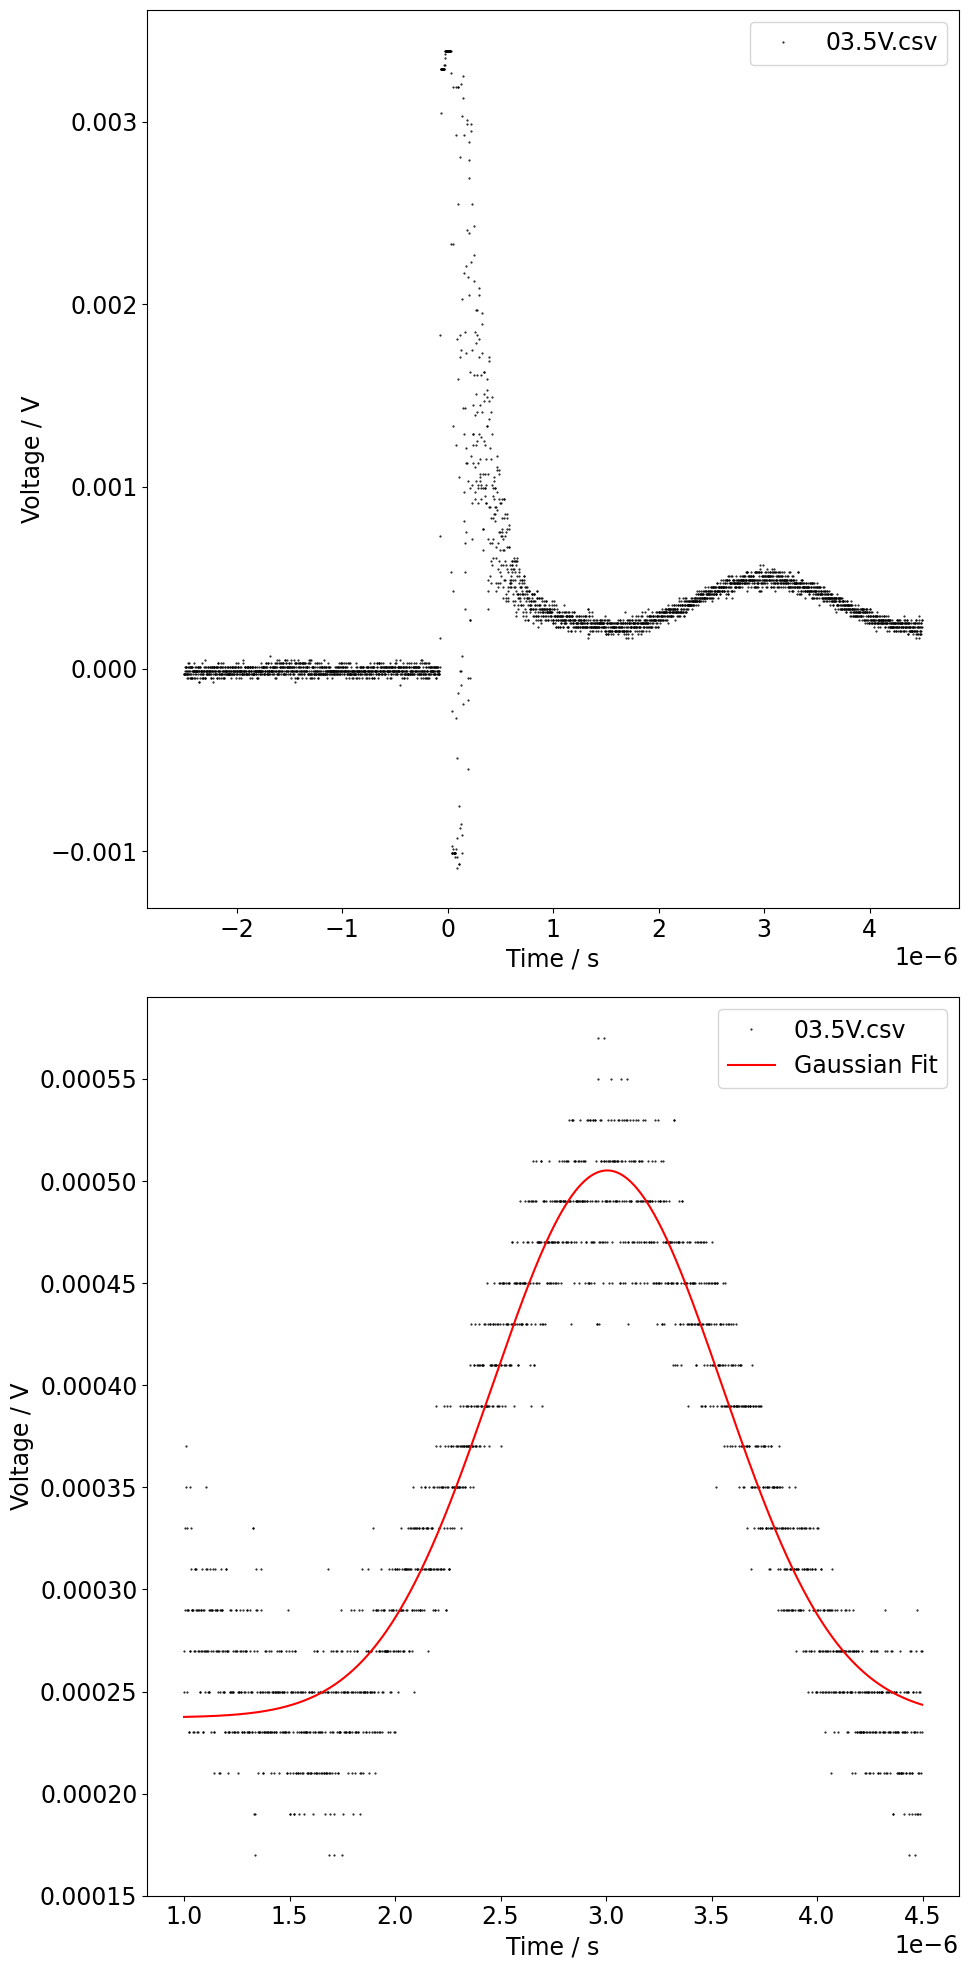

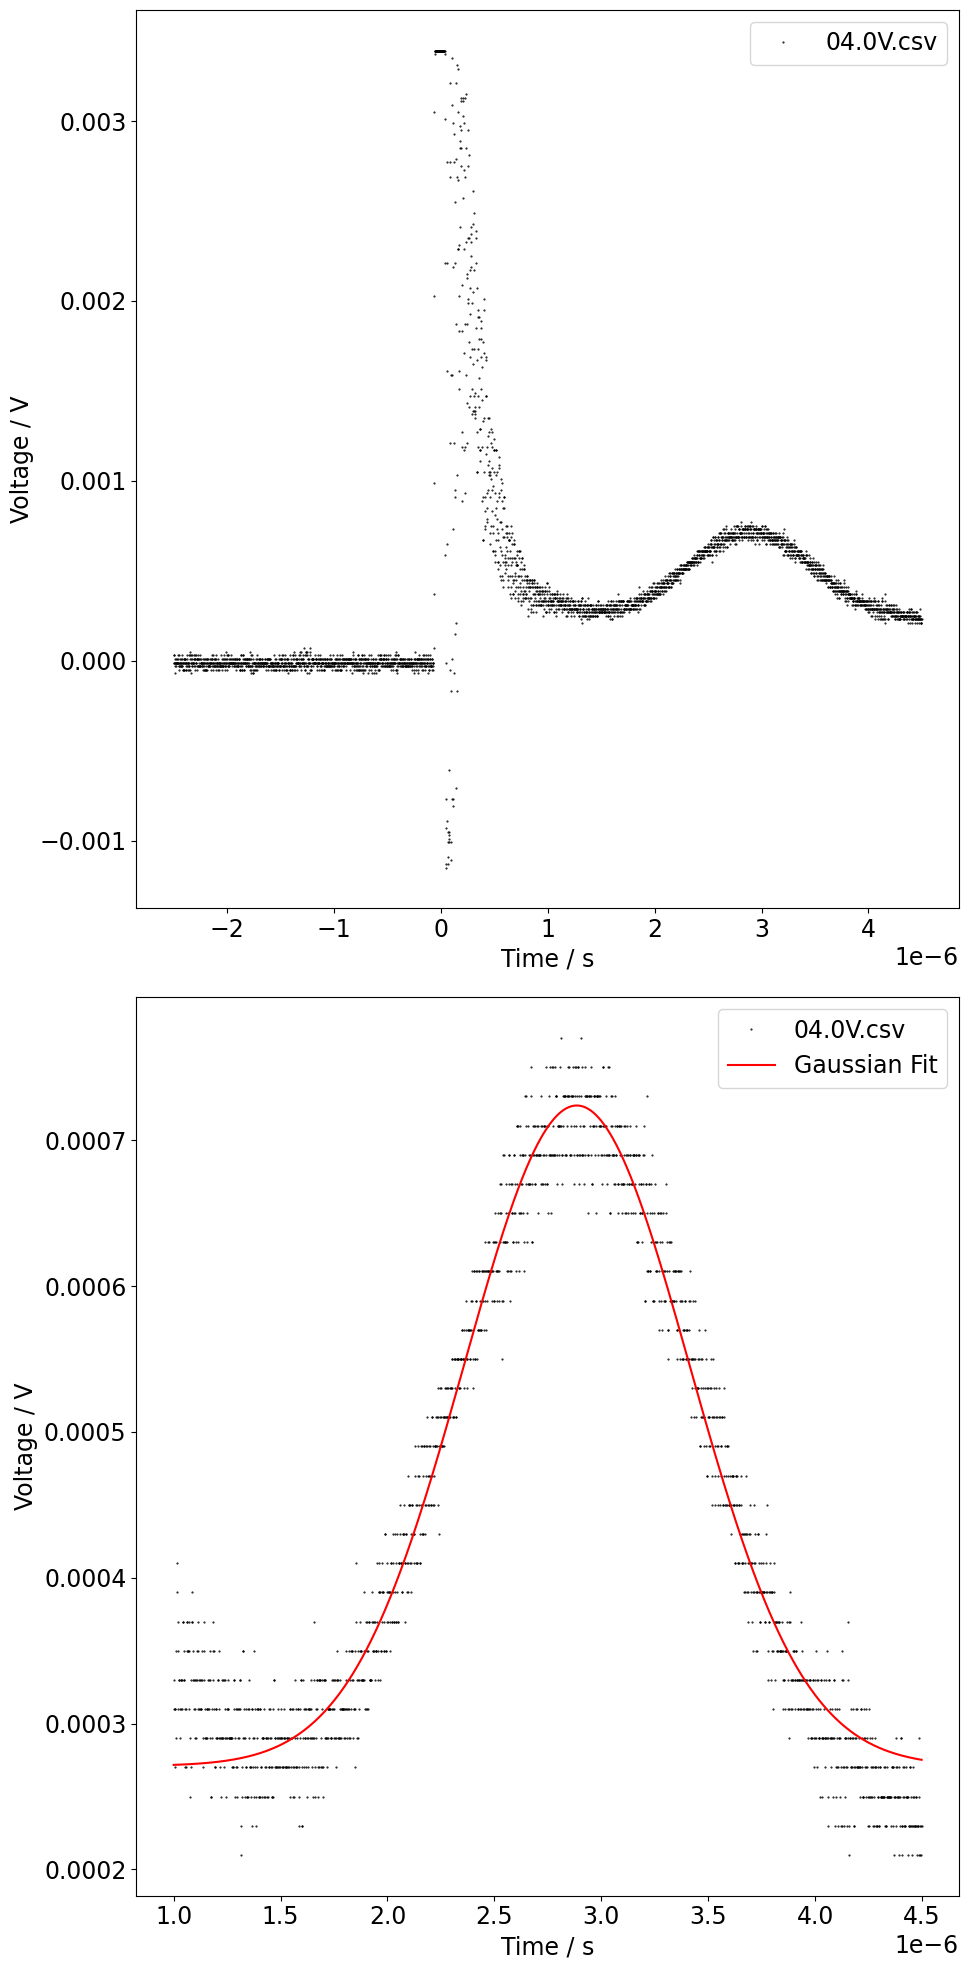

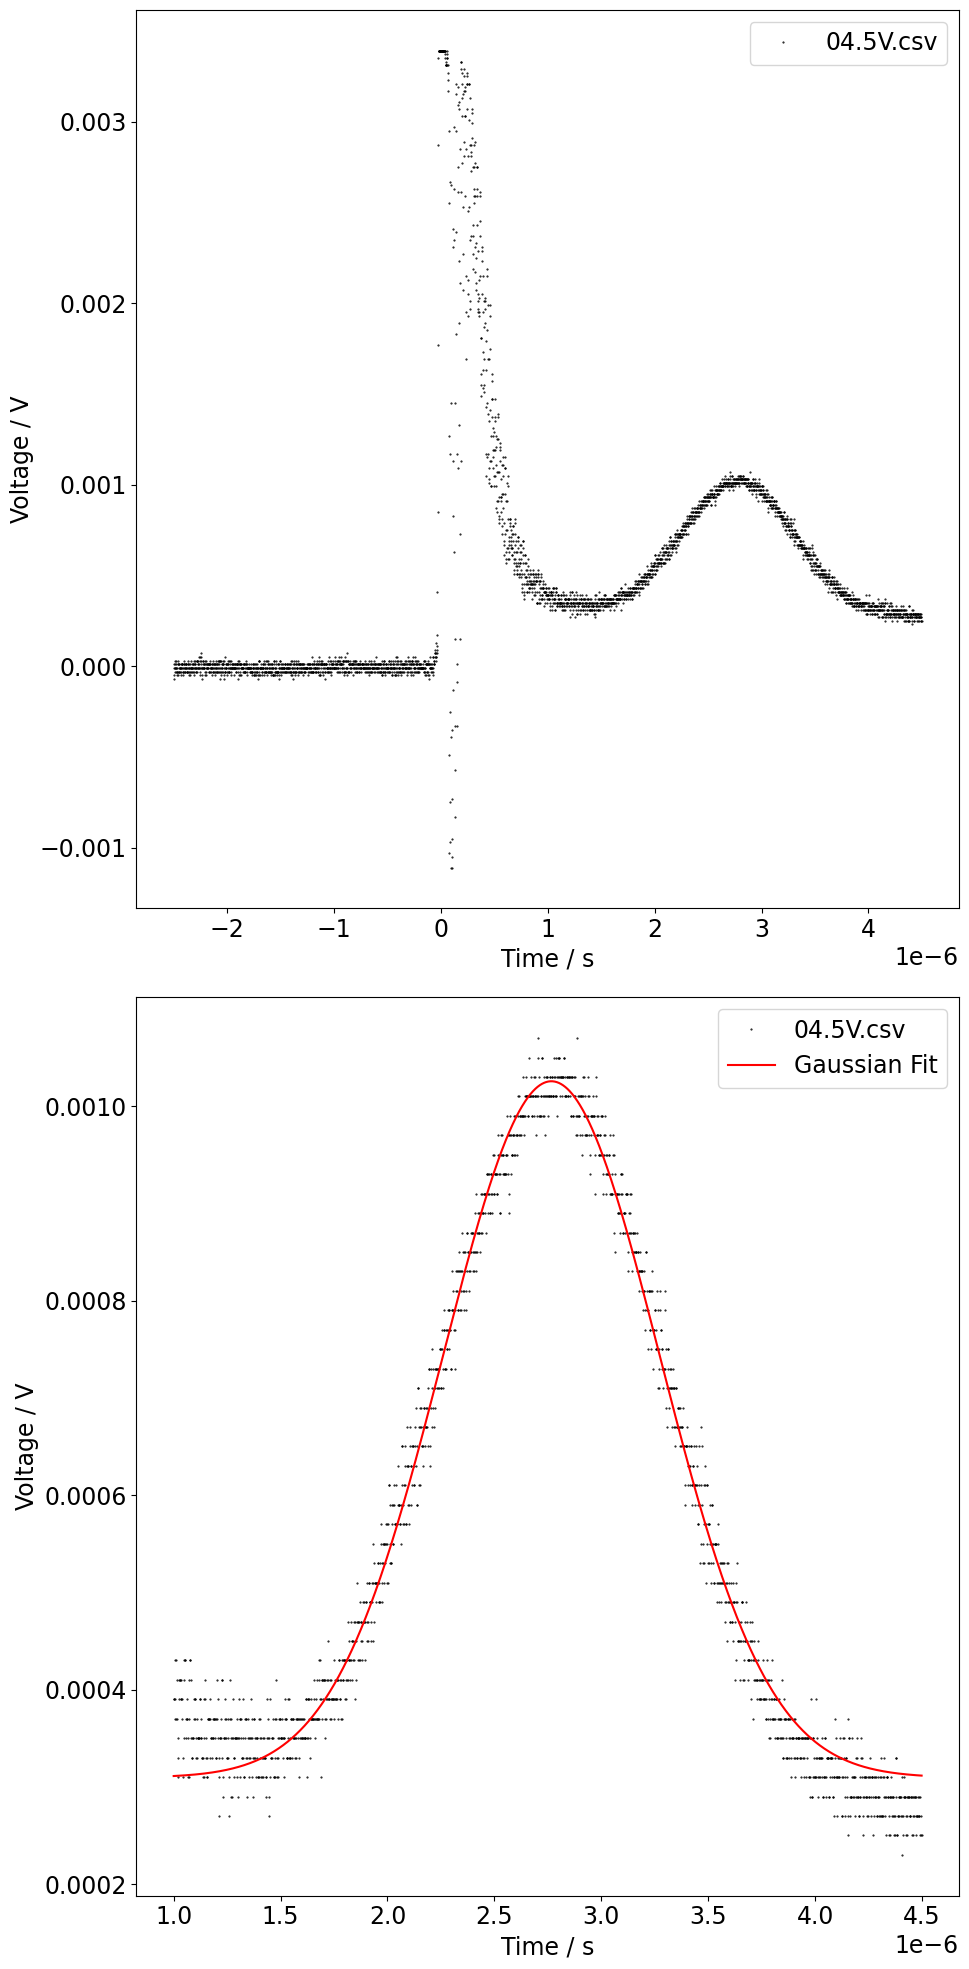

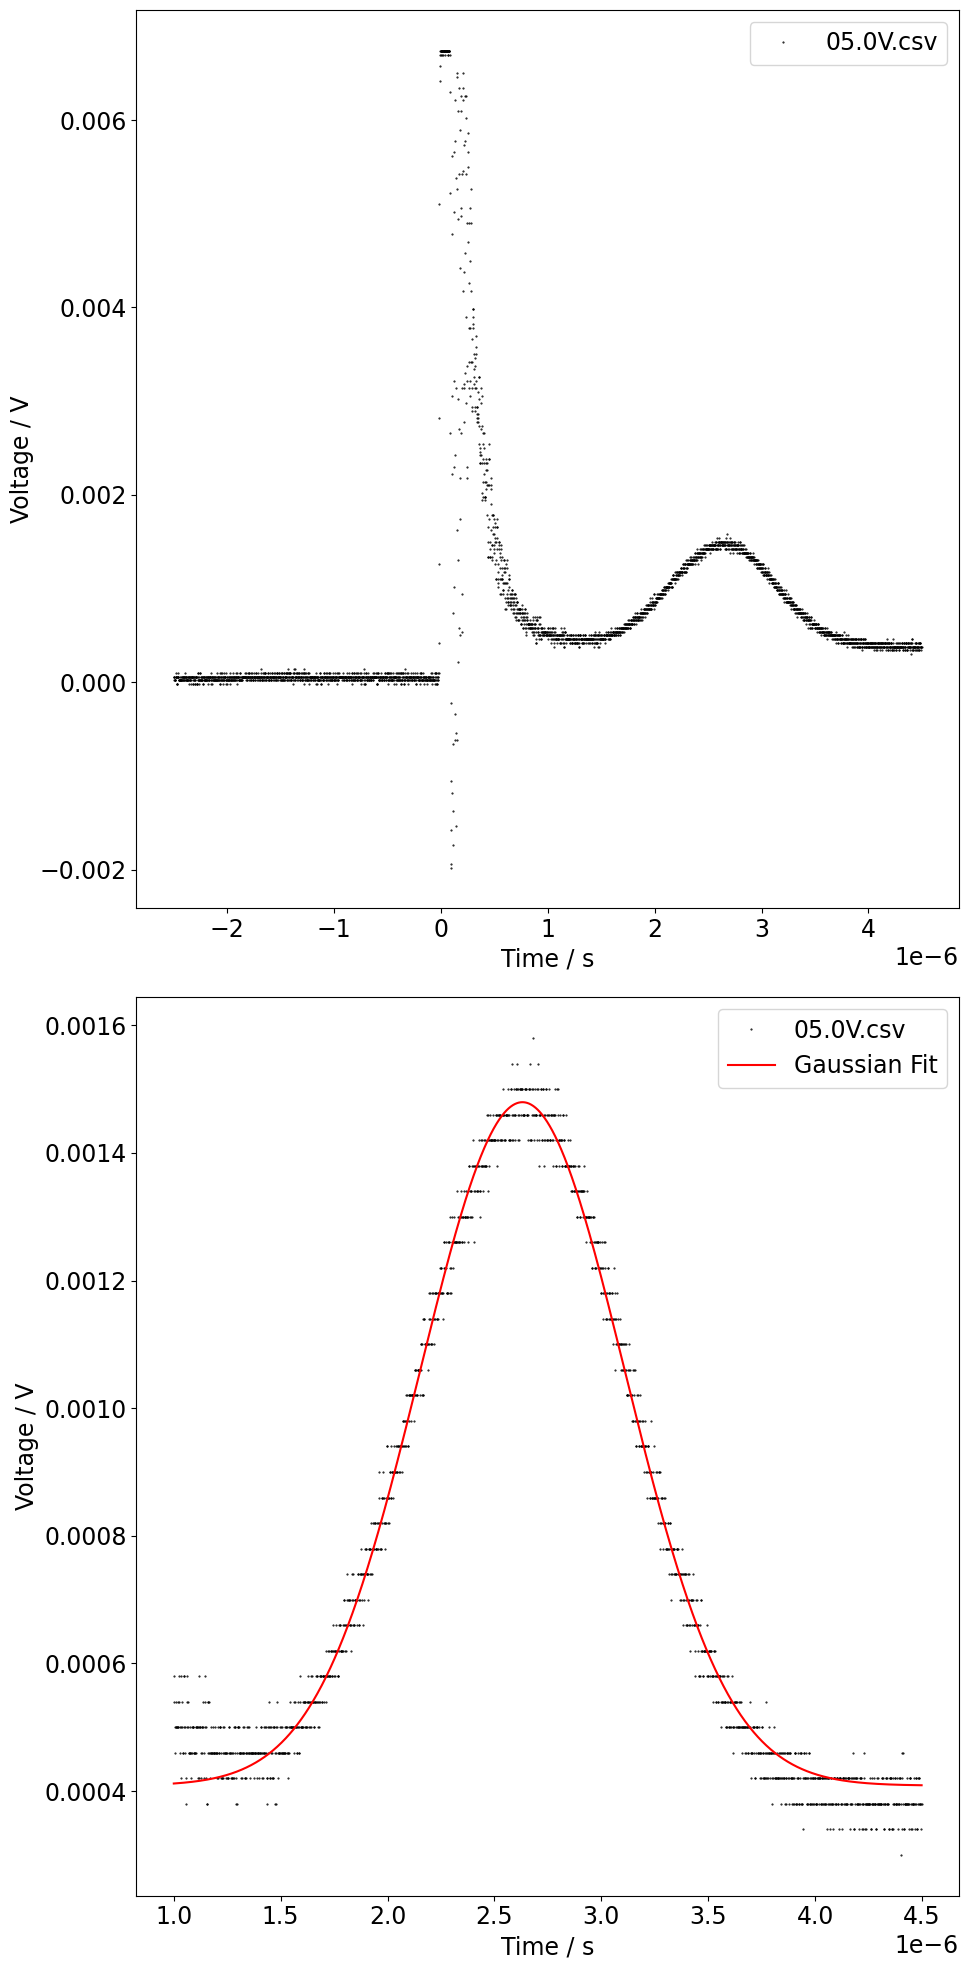

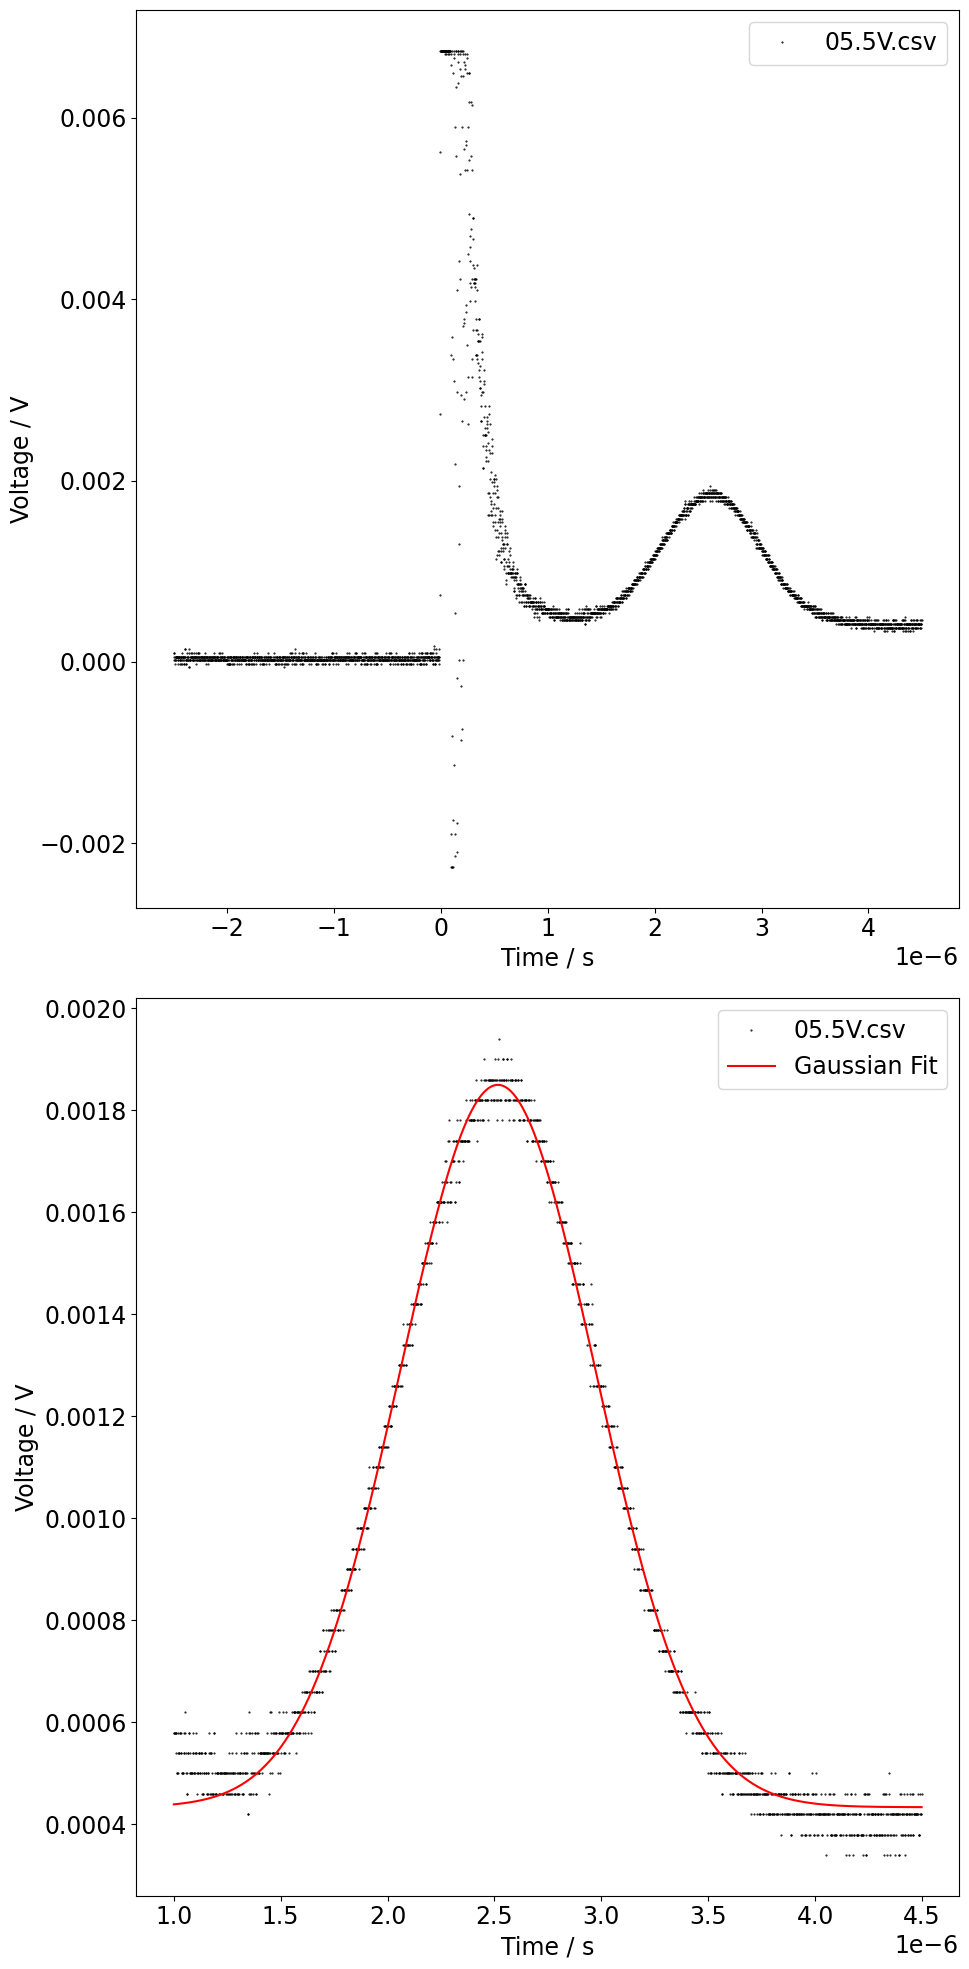

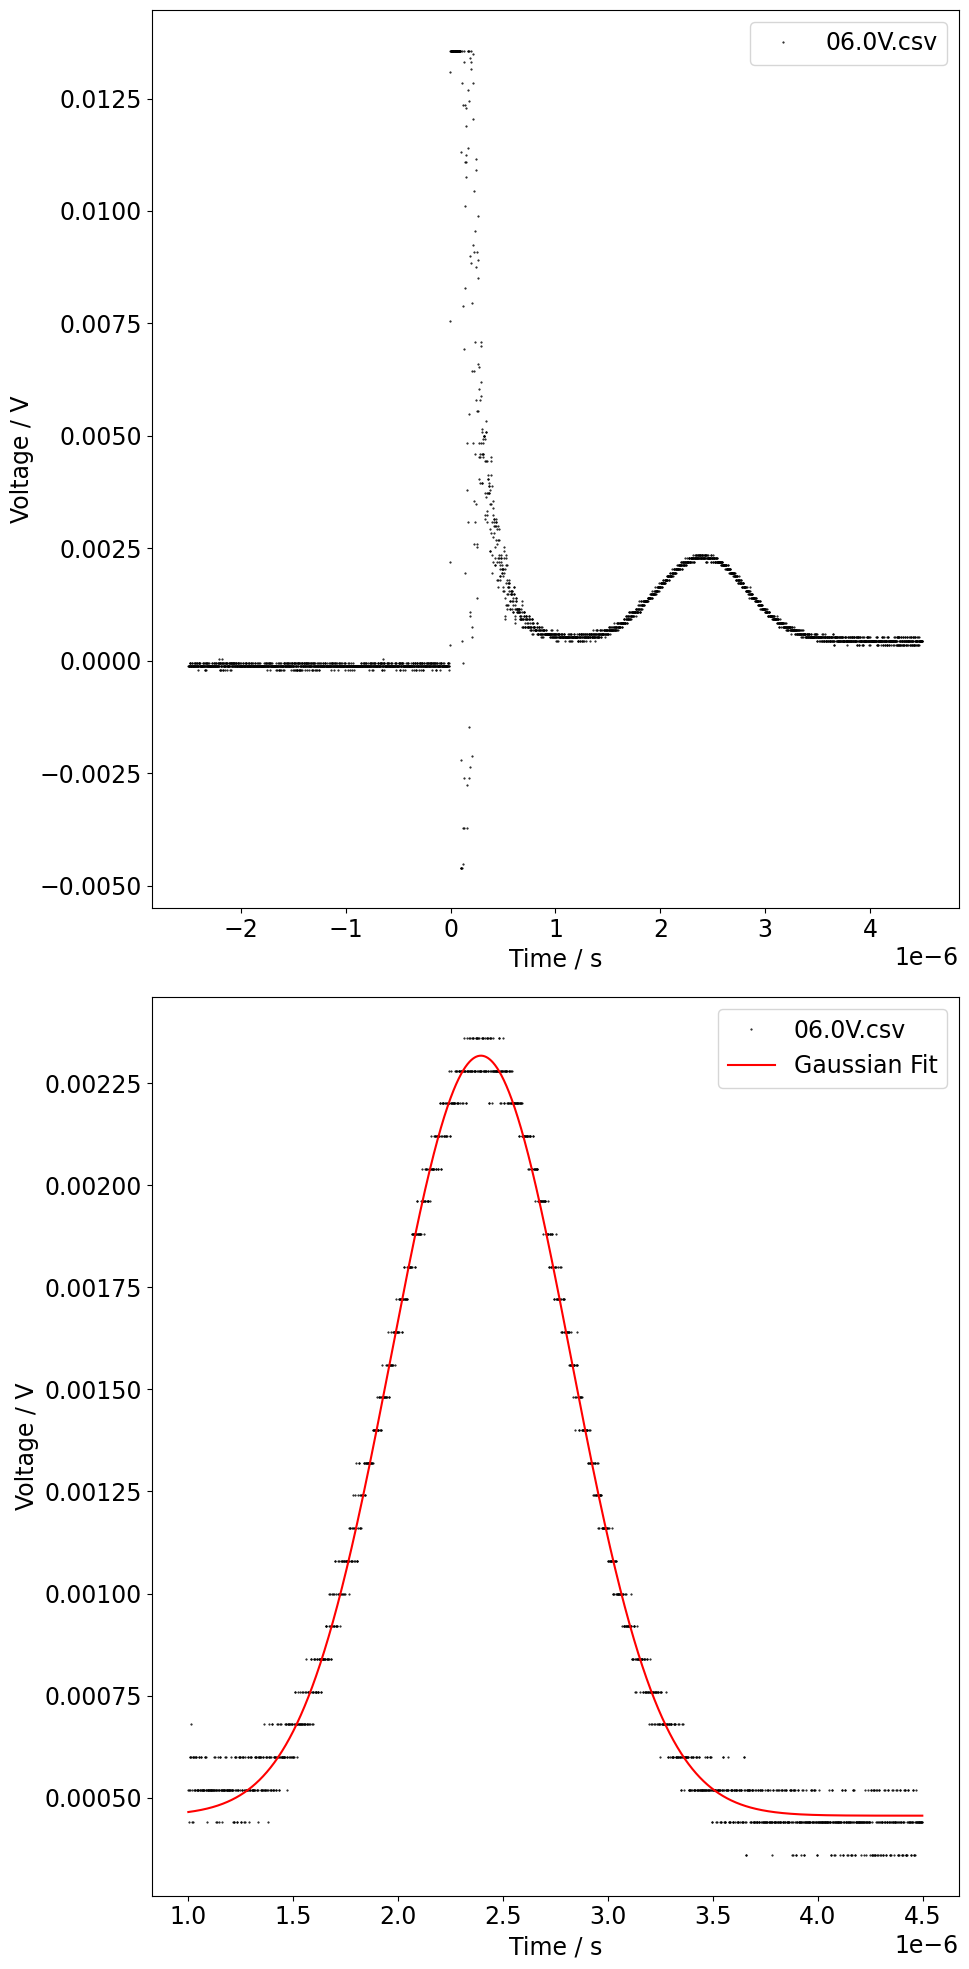

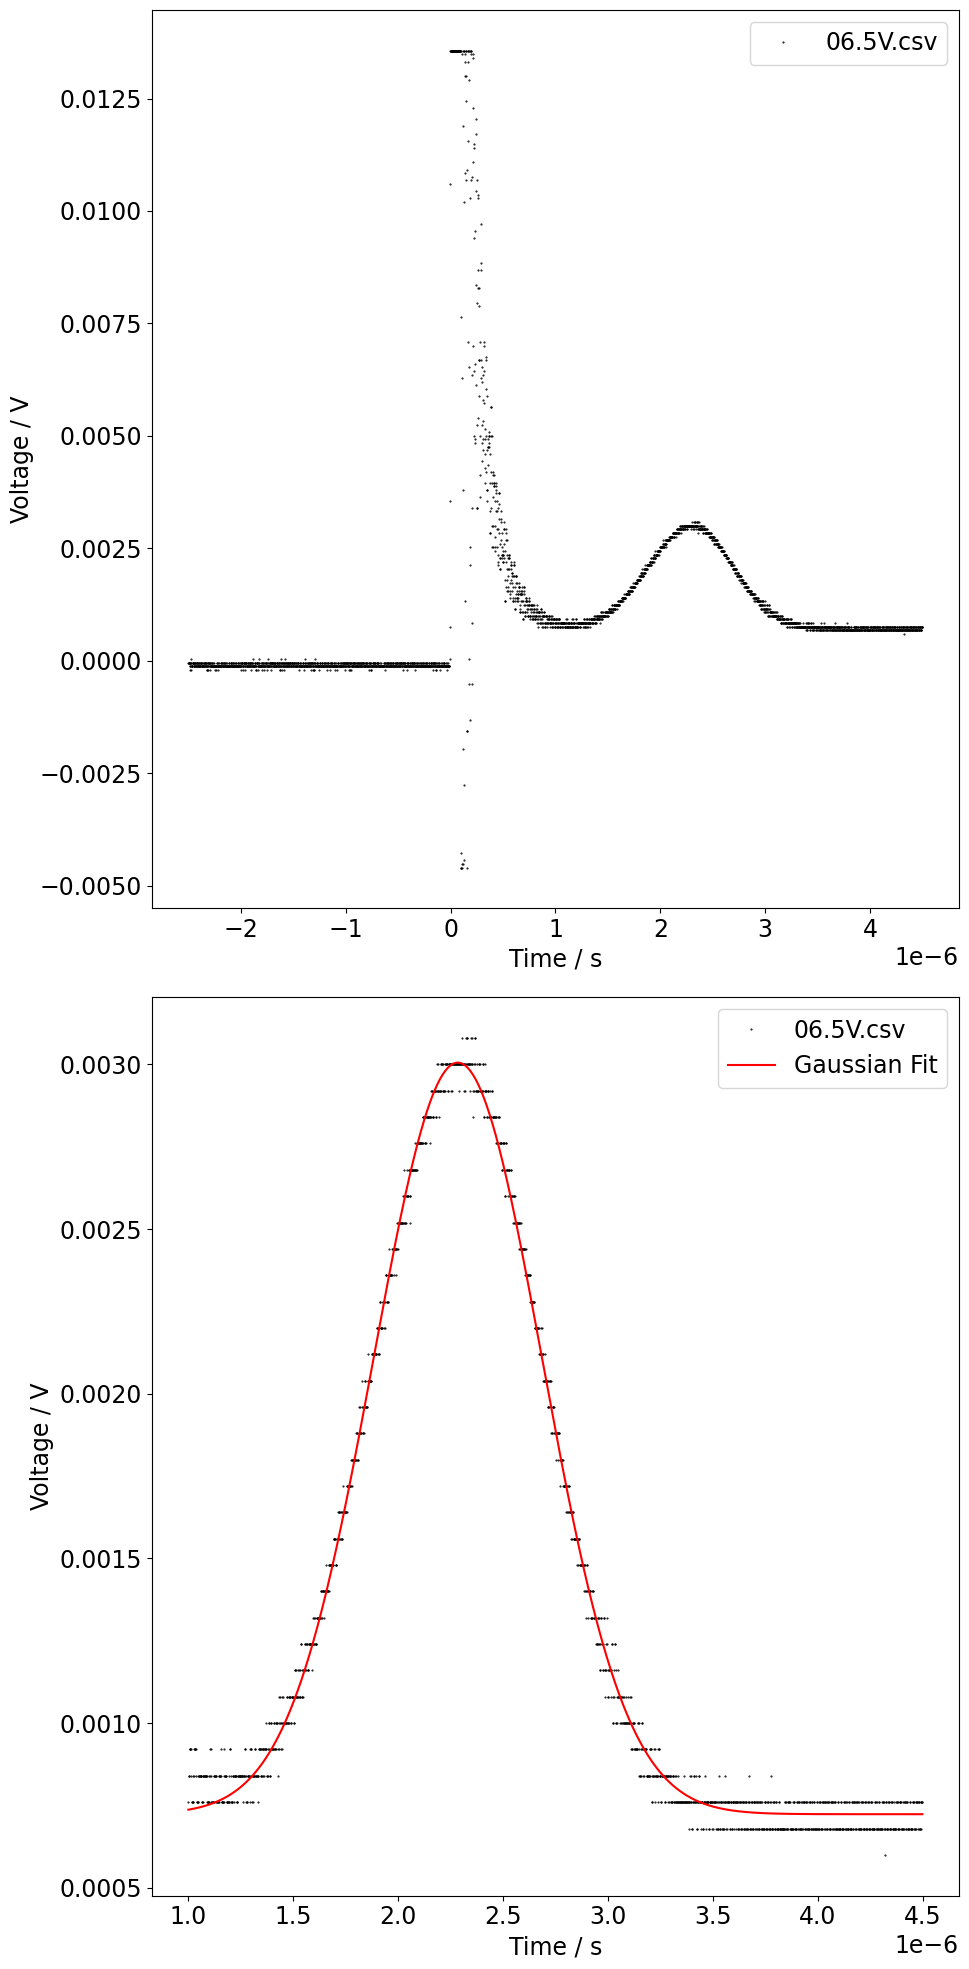

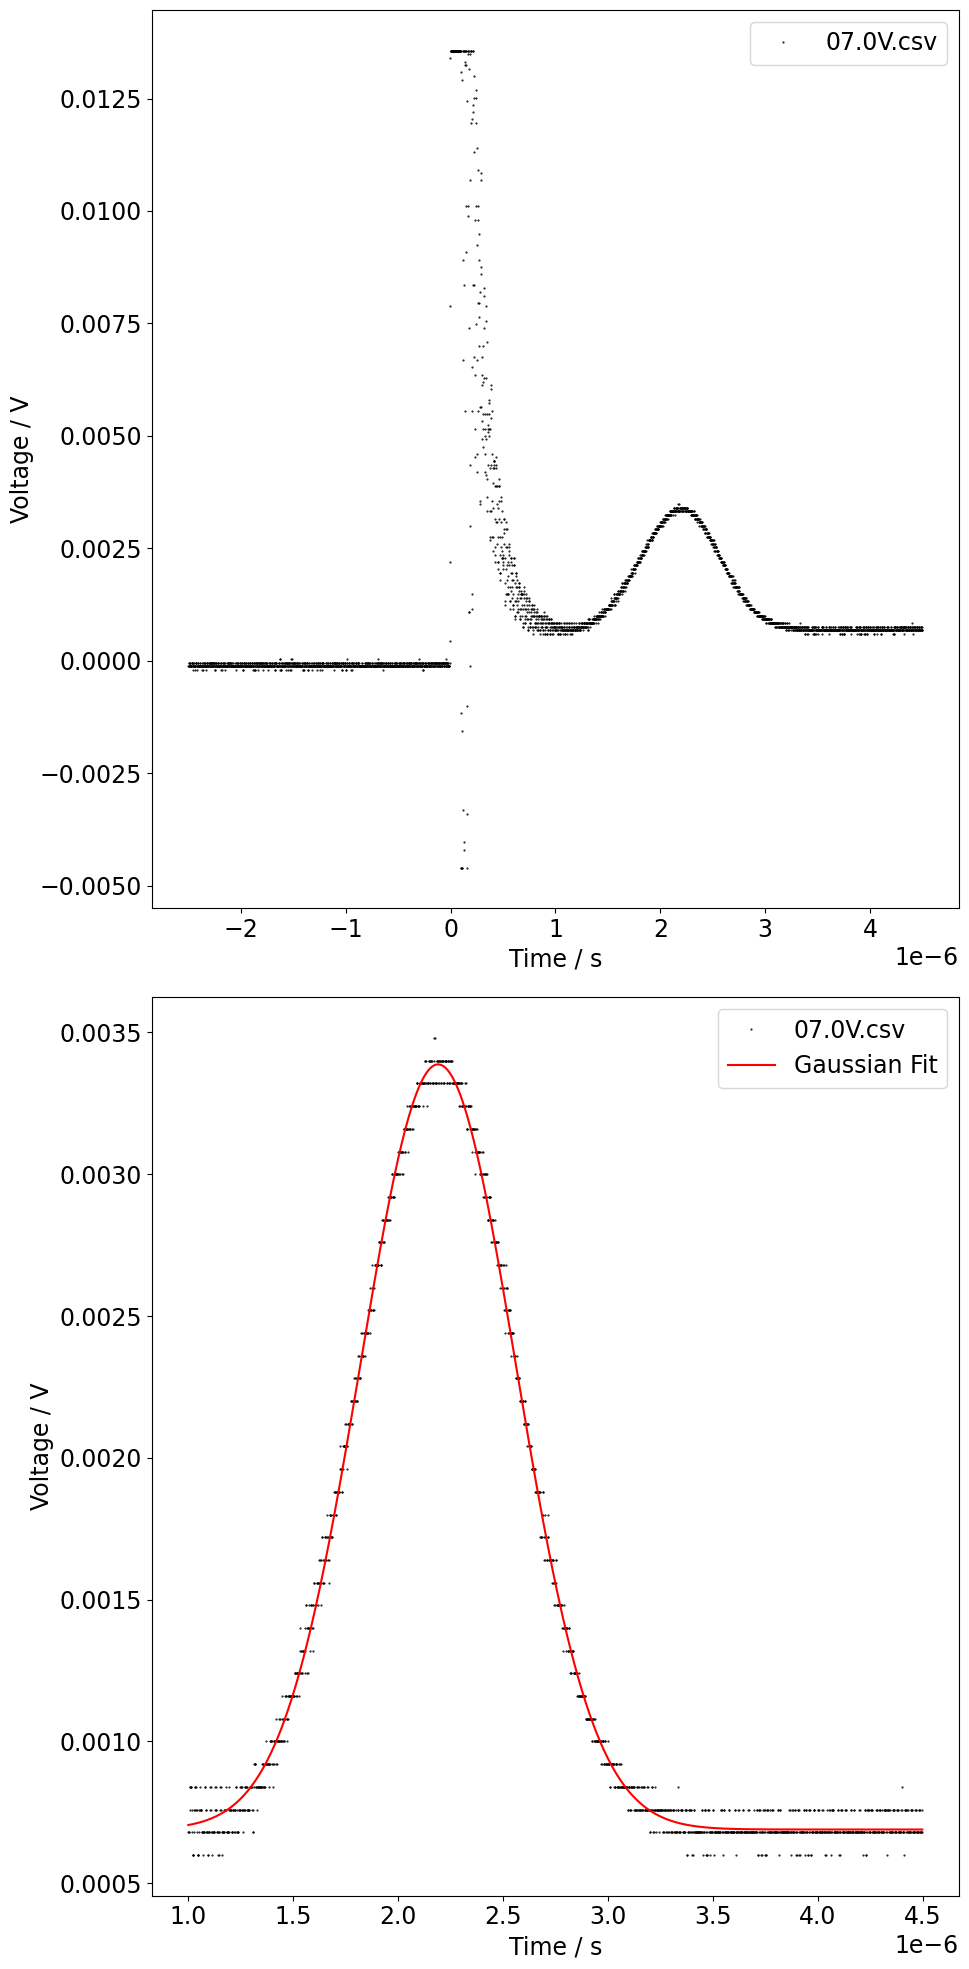

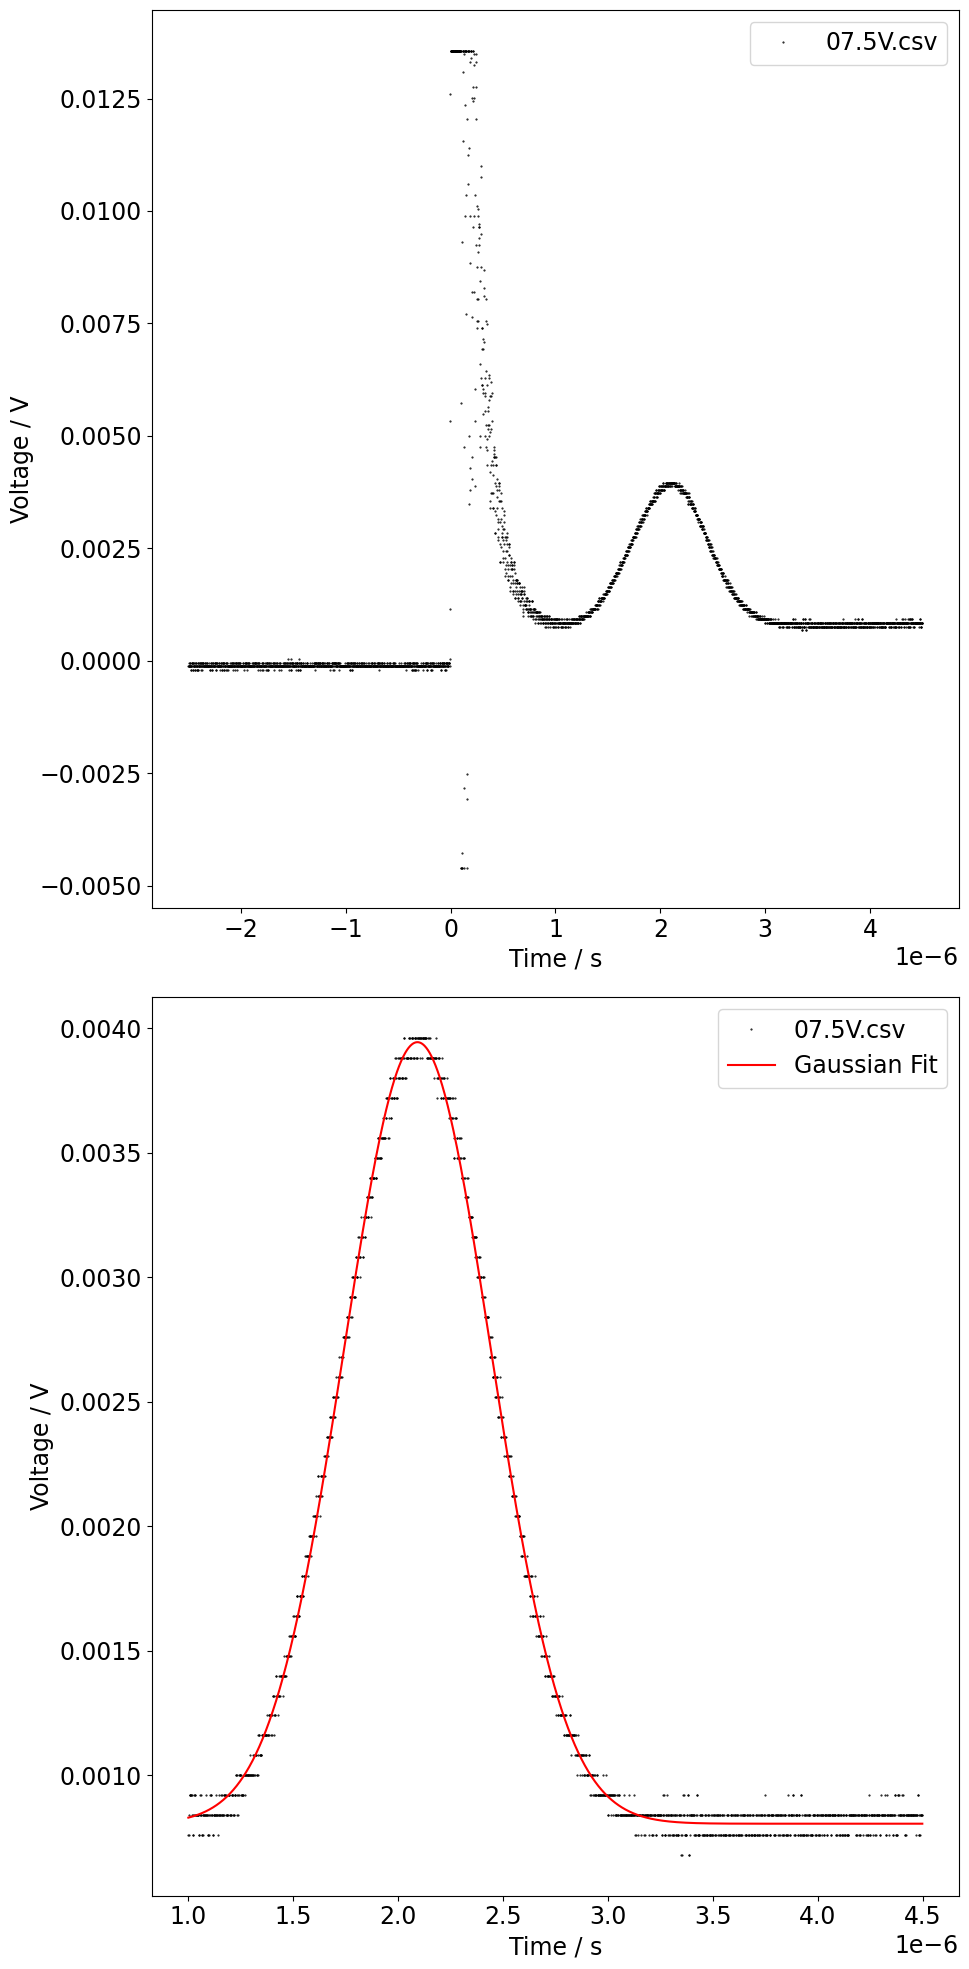

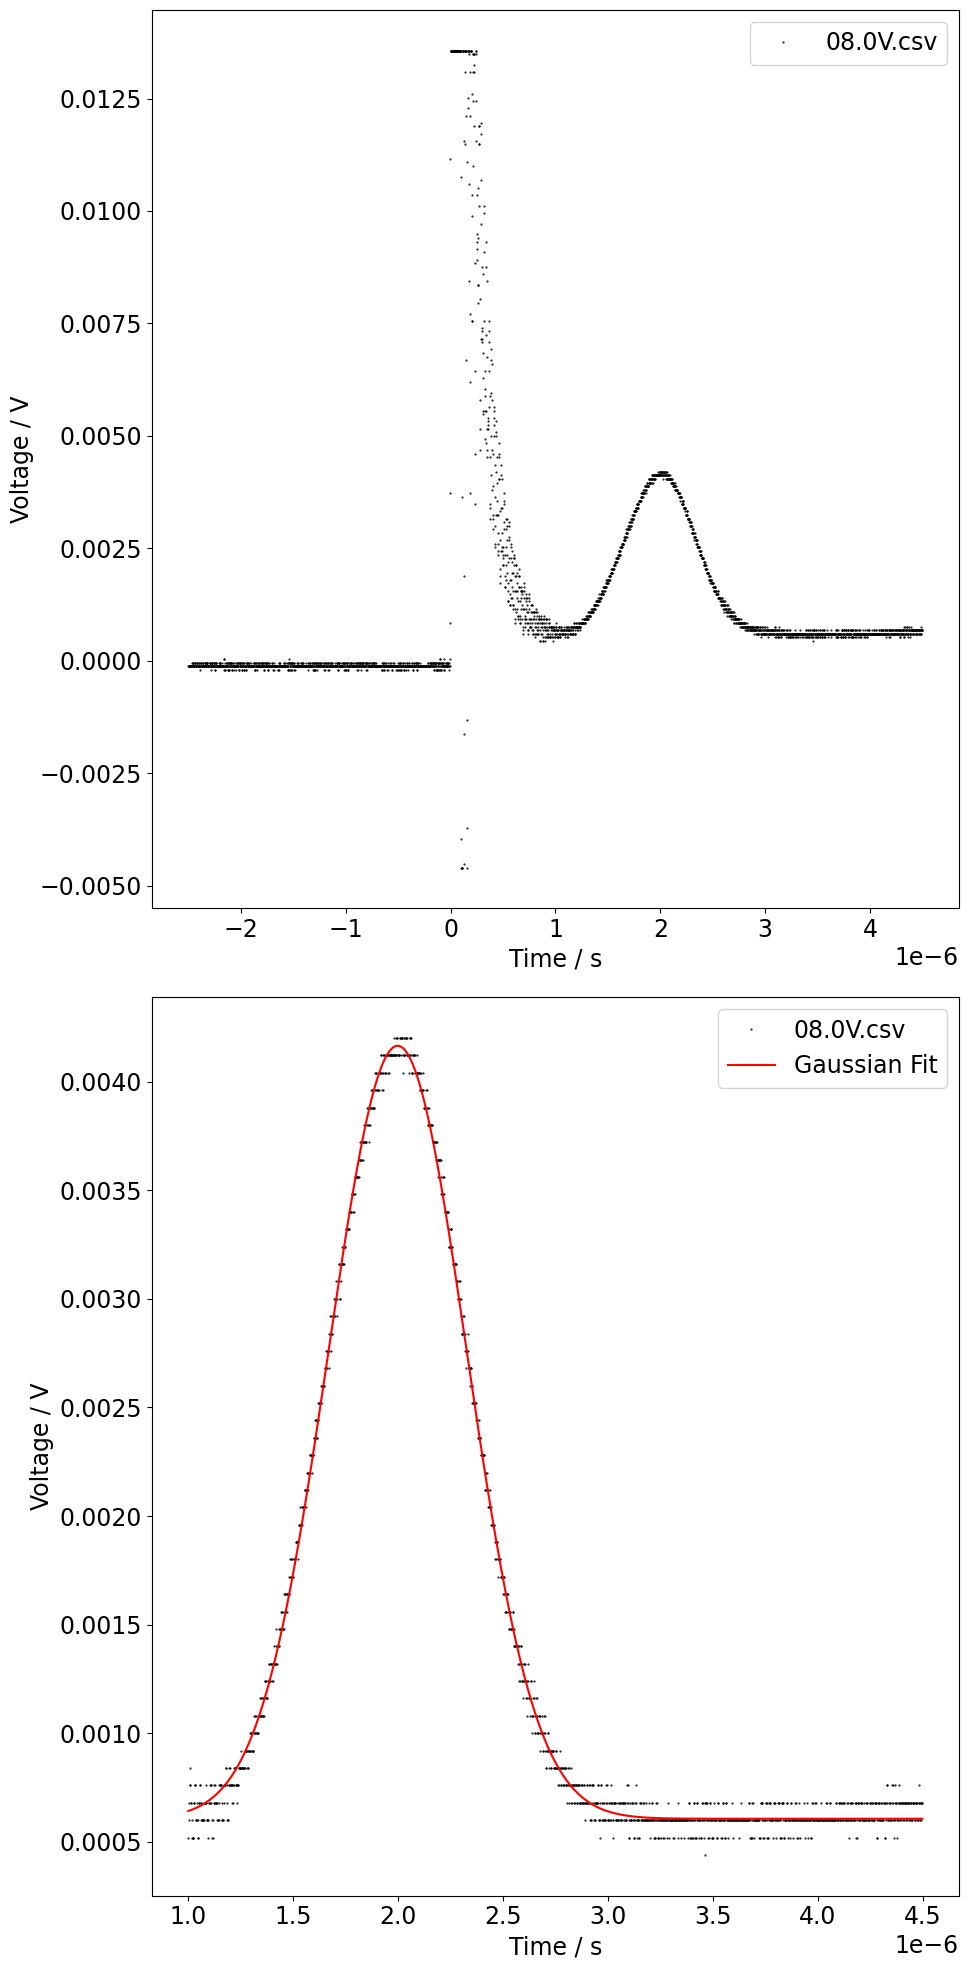

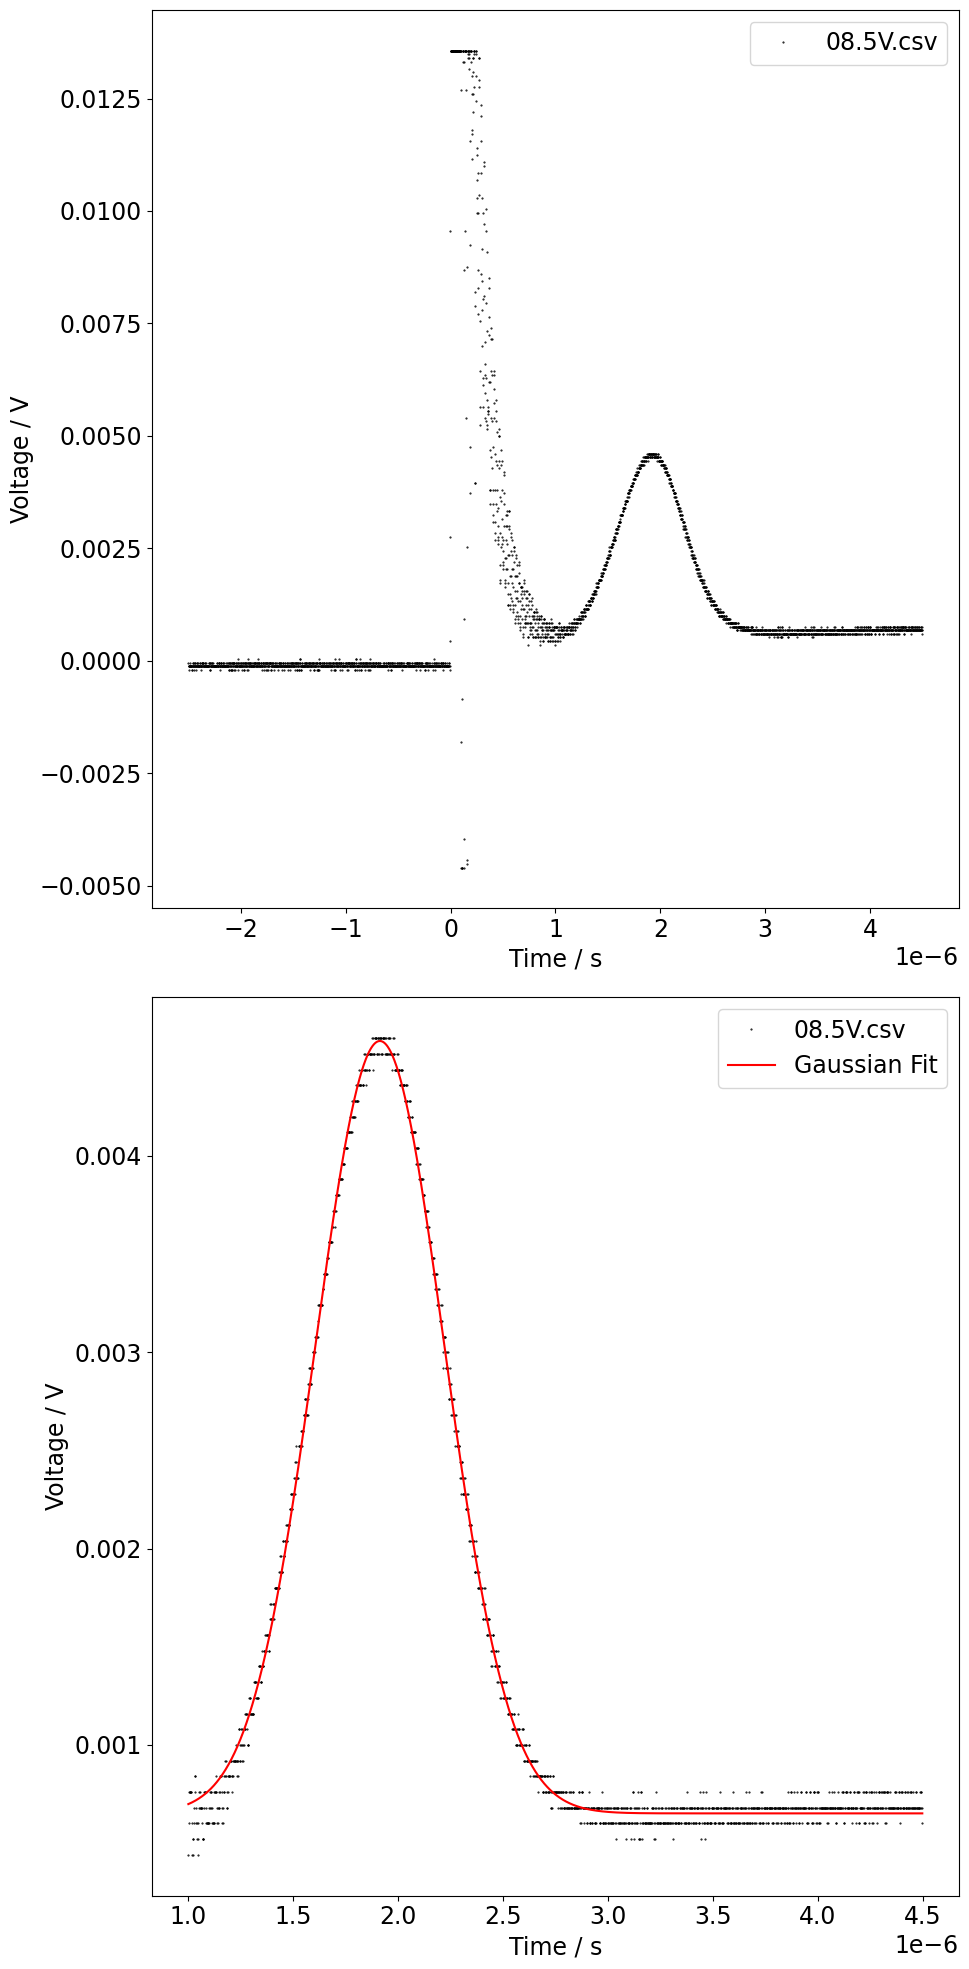

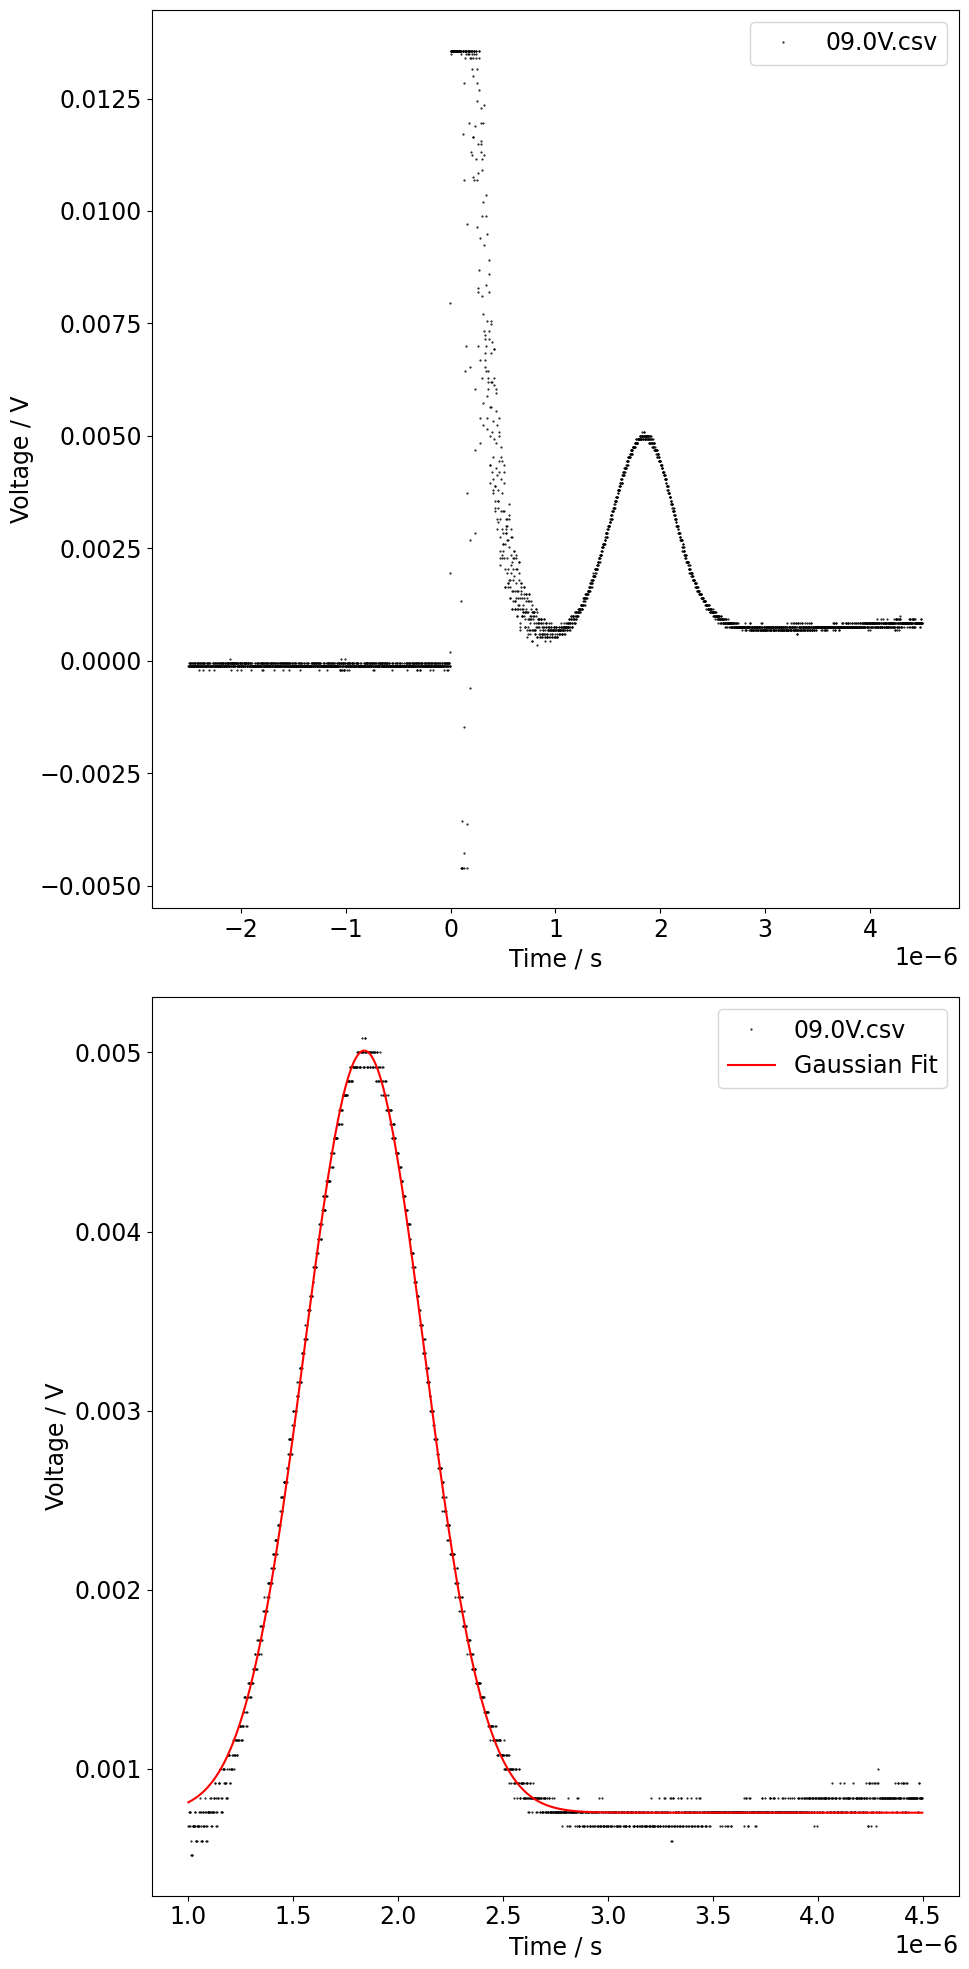

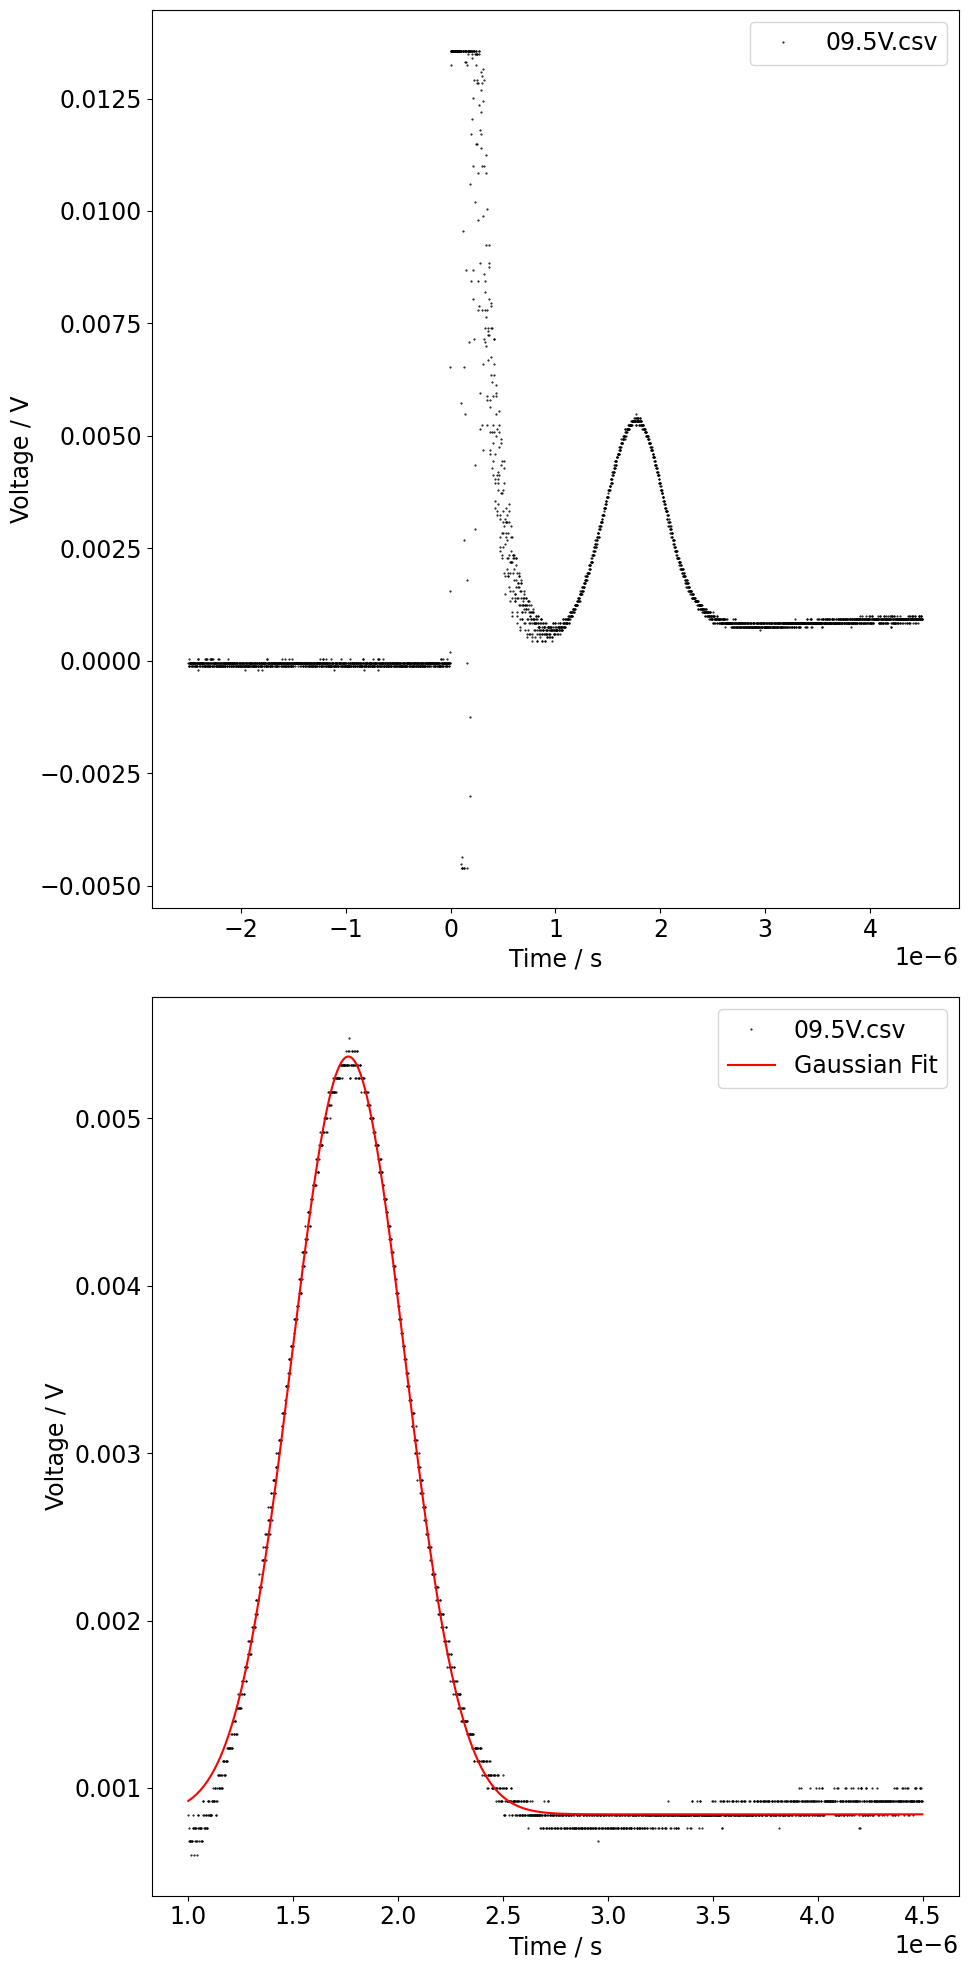

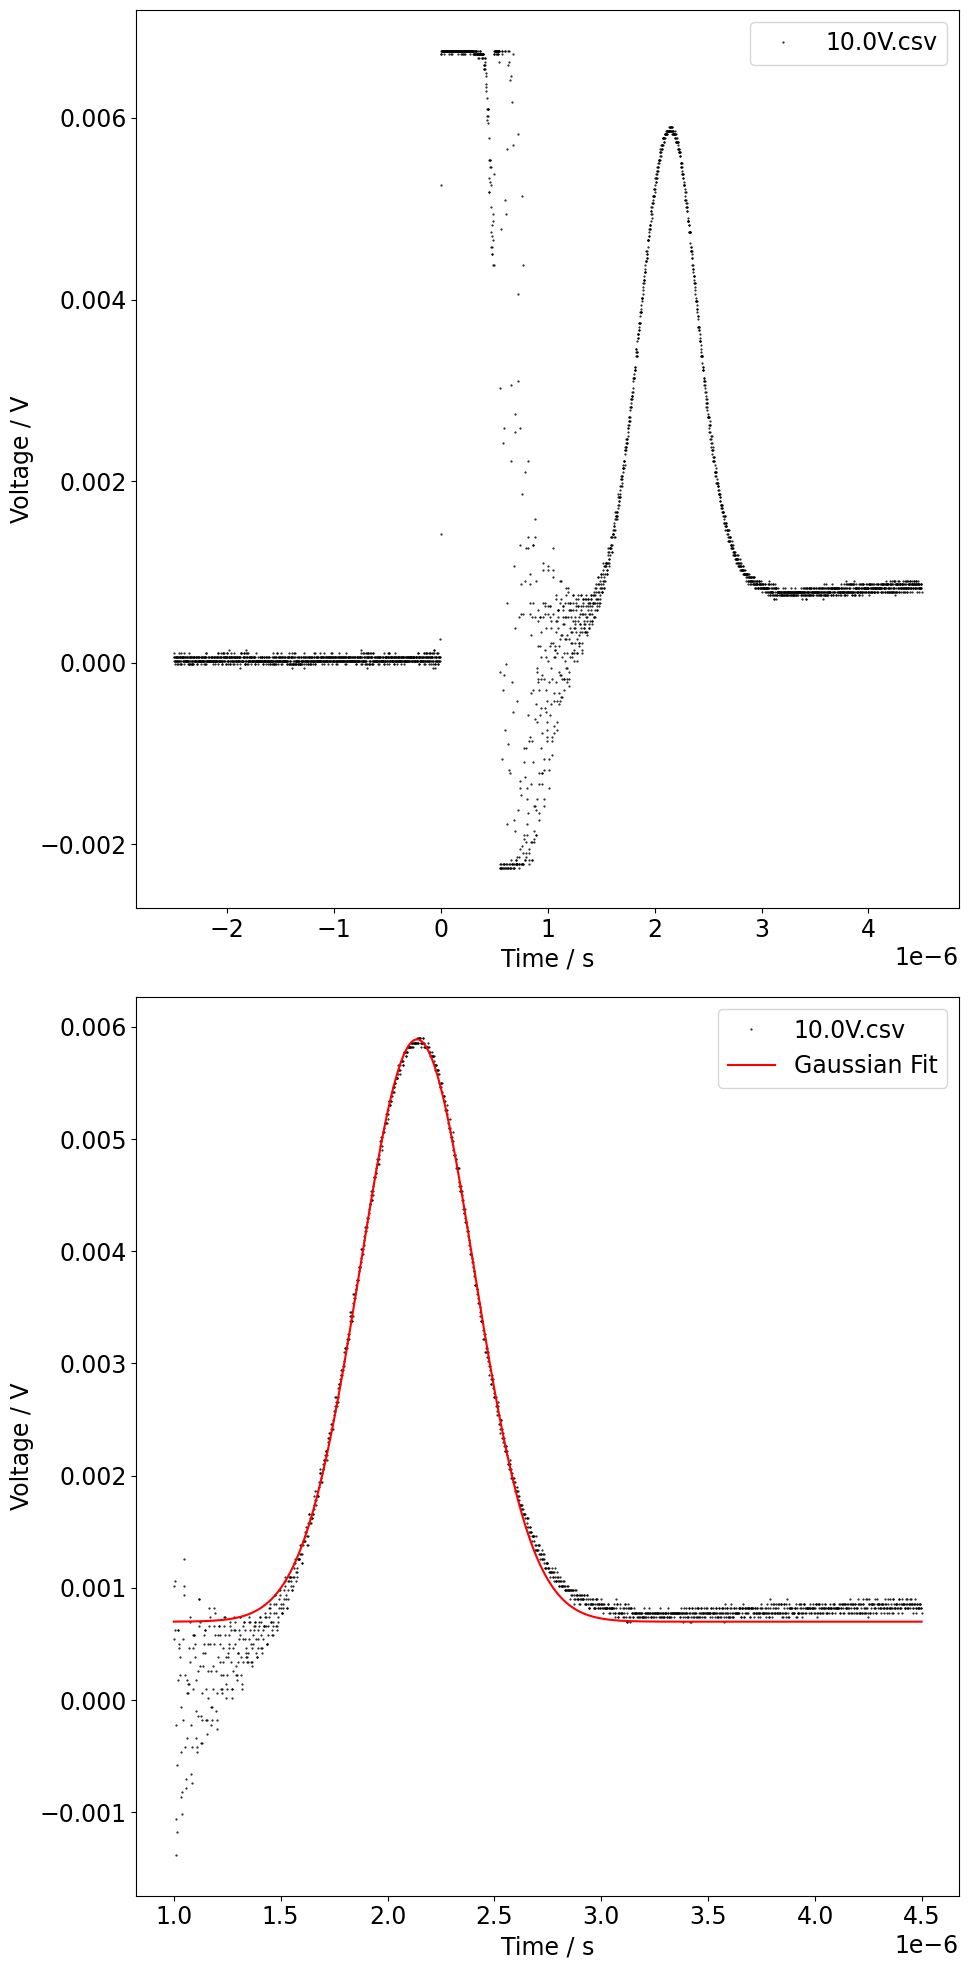

In [145]:
gaussian = lambda x, a, b, c, d: a * np.exp(-((x-b)/c)**2) + d
peak_times = np.array([])

for filename, df in c3_data.items():

    fig = plt.figure(figsize=(10, 20))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    ax1.plot(
        df["Source"],
        df["CH2"],
        label=filename,
        color="black",
        ls="None",
        marker=".",
        markersize=1,
    )


    df_curve = df[df["Source"] >= 1e-6].reset_index(drop=True) # only look at curve after 1.5us
    max_index = df_curve["CH2"].idxmax() # index of ampltiude of curve
    max_time = df_curve["Source"][max_index] # time of amplitude of curve
    peak_times = np.append(peak_times, max_time)

    ax2.plot(
        df_curve["Source"],
        df_curve["CH2"],
        label=filename,
        color="black",
        ls="None",
        marker=".",
        markersize=1,
    )

    popt, pcov = curve_fit(gaussian, df_curve["Source"], df_curve["CH2"], maxfev=50000, p0=[1, np.mean(df_curve["Source"]), np.std(df_curve["Source"]), 0])

    ax2.plot(
        df_curve["Source"],
        gaussian(df_curve["Source"], *popt),
        label="Gaussian Fit",
        color="red",
        ls="-",
    )

    ax1.set_xlabel("Time / s")
    ax1.set_ylabel("Voltage / V")
    ax1.legend()

    ax2.set_xlabel("Time / s")
    ax2.set_ylabel("Voltage / V")
    ax2.legend()

    fig.tight_layout()

## Finding Drift Velocity, Mobility ($\mu$), and the Mean Free Scattering Time ($\tau_{F}$)

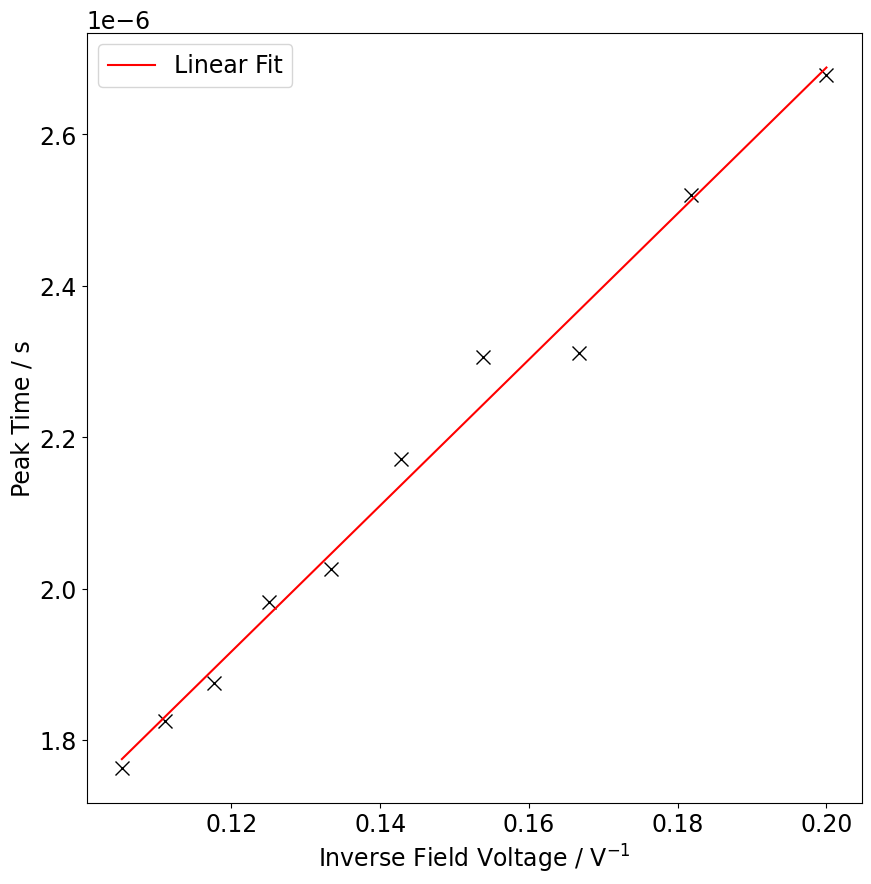

In [215]:
linear = lambda m,x,c: m*x+c
c3_voltages = np.linspace(3, 10, 15)
voltage_time_dict = dict(zip(peak_times, c3_voltages))
d_3 = 375e-6 # distance between emitter and contact 3 (C3)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(
    c3_voltages[4:-1]**-1,
    peak_times[4:-1],
    color="black",
    ls="None",
    marker="x",
    markersize=10,
)

popt, pcov = curve_fit(linear, c3_voltages[4:-1]**-1, peak_times[4:-1], maxfev=50000)
ax1.plot(
    c3_voltages[4:-1]**-1,
    linear(c3_voltages[4:-1]**-1, *popt),
    label="Linear Fit",
    color="red",
    ls="-",
)

ax1.set_xlabel("Inverse Field Voltage / V$^{-1}$")
ax1.set_ylabel("Peak Time / s")
ax1.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mobility = 370 +/- 14 cm^2 V^-1 s^-1
Thermal Velocity = 1.82e+05 m s^-1
Mean Free Scattering Time = 86.3 +/- 3.3 ps


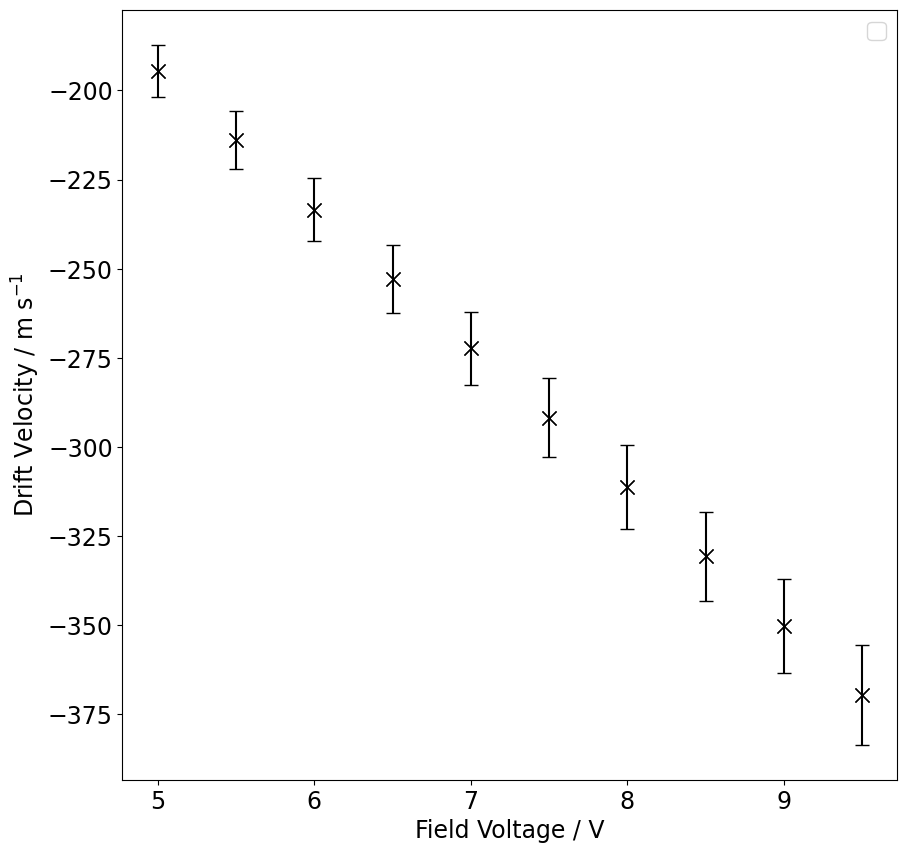

In [228]:
mobility = (d_3 * 950e-6) / popt[0]
mobility_uncertainty = mobility * (pcov[0][0]**0.5) / popt[0]
print(f"Mobility = {mobility * 1e4:.3g} +/- {mobility_uncertainty*1e4:.2g} cm^2 V^-1 s^-1")

thermal_velocity = np.sqrt((3 * 1.38e-23 * 300)/(0.41 * 9.11e-31))
print(f"Thermal Velocity = {thermal_velocity:.3g} m s^-1")

mean_free_scattering_time = (mobility * 1e3 * 0.41 * 9.11e-31)/(1.6e-19)
mean_free_scattering_time_uncertainty = mean_free_scattering_time * (mobility_uncertainty/mobility)
print(f"Mean Free Scattering Time = {mean_free_scattering_time * 1e12:.3g} +/- {mean_free_scattering_time_uncertainty*1e12:.2g} ps")

drift_velocity = - (c3_voltages[4:-1]*mobility) / 950e-6
drift_velocity_uncertainty = np.abs(drift_velocity * (mobility_uncertainty/mobility))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(
    c3_voltages[4:-1],
    drift_velocity,
    color="black",
    ls="None",
    marker="x",
    markersize=10,
)

ax1.errorbar(
    c3_voltages[4:-1],
    drift_velocity,
    yerr=drift_velocity_uncertainty,
    color="black",
    ls="None",
    marker="x",
    markersize=10,
    capsize=5
)


ax1.set_xlabel("Field Voltage / V")
ax1.set_ylabel("Drift Velocity / m s$^{-1}$")
ax1.legend()

plt.show()